# Load and save data

Up until now, we always explicitly specified file names. If we want something more flexible (e.g., when working with multiple subjects, there is a nice interface for that:
* [SelectFiles](http://nipy.org/nipype/users/select_files.html)


---
Up until now, we only lookt at data in the working directory. Usually, we are not interested in intermediate results. We can create an output directory that has only the data we want to store permatently:
* [Data Sink](http://nipy.org/nipype/interfaces/generated/nipype.interfaces.io.html#datasink)

In [1]:
import os

home = os.path.expanduser('~')
data_path = os.path.join(home, 'nipype_data')
wd_path = os.path.join(data_path, '05_load_save')
if not os.path.exists(wd_path):
    os.mkdir(wd_path)
os.chdir(wd_path)
print(wd_path)

/Users/franzliem/nipype_data/05_load_save


# Workflow

Let's take the previous workflow 

In [2]:
from nipype.pipeline.engine import Node, Workflow
from nipype.interfaces import fsl

workflow_path = os.path.join(wd_path, 'wf')
wf = Workflow(name='load_save_wf')
wf.base_dir = workflow_path
wf.config['execution']['crashdump_dir'] = os.path.join(workflow_path, 'crash')
wf.config['execution']['remove_unnecessary_outputs'] = False

In [3]:
moco = Node(fsl.MCFLIRT(), 'moco')

smoothing = Node(fsl.IsotropicSmooth(), 'smoothing')
smoothing.inputs.fwhm = 6

wf.connect(moco, 'out_file', smoothing, 'in_file')

Note that we only connected the two nodes, we did not define input data

# SelectFiles

In [4]:
from nipype.interfaces.io import DataSink, SelectFiles

In [5]:
file_template = {'rs': 'in_data/s01/rs_10TRs.nii.gz'}

selectfiles = Node(SelectFiles(file_template, base_directory=data_path),
                   name="selectfiles")

Now we connect selectfiles to moco:

In [6]:
wf.connect(selectfiles, 'rs', moco, 'in_file')

If we had more than one file we could define the template like this:

In [7]:
file_template = {'rs': 'in_data/s01/rs_10TRs.nii.gz',
                't1w':'in_data/s01/t1w.nii.gz'}

# DataSink

In [8]:
ds_dir = os.path.join(wd_path, 'output')

ds = Node(DataSink(), name='ds')
ds.inputs.base_directory = ds_dir

compare the style of the base_directory definintion of selectfiles. They work interchangeably

We can use substitutions to, e.g., replace 'subject_id_s01' with 's01' by defining:

In [9]:
ds.inputs.regexp_substitutions = [
    ('subject_id_', '')
]

Now we connect the output of smoothing with datasink

In [10]:
wf.connect(smoothing, 'out_file', ds, 'smoothed_data')

and run the workflow

In [11]:
wf.run()

/Users/franzliem/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/Users/franzliem/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running serially.
INFO:workflow:Executing node selectfiles in dir: /Users/franzliem/nipype_data/05_load_save/wf/load_save_wf/selectfiles
INFO:workflow:Executing node moco in dir: /Users/franzliem/nipype_data/05_load_save/wf/load_save_wf/moco
INFO:workflow:Running: mcflirt -in /Users/franzliem/nipype_data/in_data/s01/rs_10TRs.nii.gz -out /Users/franzliem/nipype_data/05_load_save/wf/load_save_wf/moco/r

INFO:workflow:Creating detailed dot file: /Users/franzliem/nipype_data/05_load_save/wf/load_save_wf/graph_detailed.dot
INFO:workflow:Creating dot file: /Users/franzliem/nipype_data/05_load_save/wf/load_save_wf/graph.dot


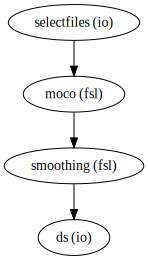

In [12]:
wf.write_graph(dotfilename='graph', graph2use='orig', format='svg')
from IPython.display import SVG, display
display(SVG(filename='wf/load_save_wf/graph.dot.svg'))

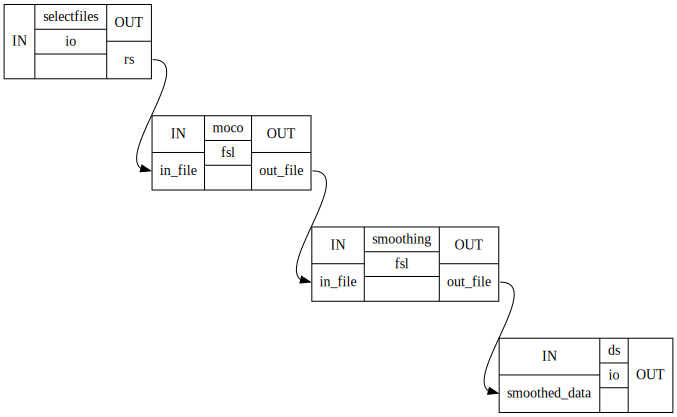

In [13]:
display(SVG(filename='wf/load_save_wf/graph_detailed.dot.svg'))

We can create __subdirectories__ like this:

In [14]:
wf.connect(smoothing, 'out_file', ds, 'smoothed_data.functional')